# Hashtag Analysis and relationship with MMR graph data

In [1]:
import snap
from snap import TUNGraph
import os
import sys
import operator
import pandas as pd
import subprocess
import numpy as np
import csv
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
from __future__ import print_function
from IPython.display import HTML, display
import tabulate
import json
import datetime
from datetime import timedelta
from collections import Counter
import re

# Set Seaborn defaults
sns.set()
%matplotlib inline
pd.set_option("display.precision", 3)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.autolayout'] = True

# Global variables
data_dir = "../data"
pictures_path = os.path.join("../Pictures", "6.HashtagAnalysis")
tweets_path = "../lib/GetOldTweets-python/out/completed"

In [2]:
# Import the biggest connected component to work on
FIn = snap.TFIn("../data/mmr_max_connected_component.bin")
graph = snap.TUNGraph.Load(FIn)

In [331]:
def read_large_file(file_object):
    while True:
        data = file_object.readline()
        if not data:
            break
        yield data.rstrip('\n')

In [5]:
hashtag = "jesuischarlie"
hashtag_full = "#JeSuisCharlie"

In [333]:
%%time
tweets_filename = os.path.join(tweets_path,"tweets_#" + hashtag + "_2013-09-01_2016-12-31.json")
tweets = []
with open(tweets_filename) as fin:
    for line in read_large_file(fin):
        tweets.append(json.loads(line))
print("Imported %d tweets from %s" %(len(tweets),tweets_filename))

Imported 413857 tweets from ../lib/GetOldTweets-python/out/completed/tweets_#jesuischarlie_2013-09-01_2016-12-31.json
CPU times: user 10.3 s, sys: 252 ms, total: 10.6 s
Wall time: 10.5 s


Given the main graph, I have to identify the subgraph of nodes (usernames) that have been part of a Twitter conversation that involved the concerned hashtag. This means that I would consider node $i$ part of the subnet if one of the following occurs:
- $i$ has **tweeted** using hashtag $h$;
- $i$ has been **mentioned**/**replied to** by someone that used hashtag $h$;
- $i$ has tweeted a status that has been **retweeted**/**quoted** by someone else that used hashtag $h.$

Of course this operation is not immediate and trivial, since the usernames will be collected first as a set of actual Twitter screen names, which have to be mapped to their specific encoding afterwards. As a first example, I'm going to carry out the analysis by considering a single hashtag, then I'll extend the same analysis to multiple hashtags.

**#JeSuisCharlie** refers to the Charlie Hebdo shooting in France occurred on January 7th 2015, and by extension, a supporter of freedom of speech and resistance to armed threats. Some journalists embraced the expression as a rallying cry for the freedom of self-expression.

# 1. Extract Hashtag Subgraph
Let's collect all the usernames from the downloaded tweets and keep only the ones that are part of our MMR data.

In [334]:
def get_usernames_from_basic_tweet_info(hashtag, tweet):
    usernames = set()
    # (1): Has tweeted using hashtag
    if hashtag in [h.lower() for h in tweet["entities"]["hashtags"]]:
        usernames.add(tweet["user"]["screen_name"].lower())

    # (2): Has been mentioned / replied to
    if not tweet["in_reply_to_screen_name"] is None:
        usernames.add(tweet["in_reply_to_screen_name"].lower())
    for mentions in tweet["entities"]["user_mentions"]:
        usernames.add(mentions["screen_name"].lower())
    return usernames

def extract_hashtag_usernames(hashtag, tweets):
    hashtag_usernames = set()
    for tweet in tweets:
        hashtag_usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet))
   
        # (3): Retweeted / Quoted status
        if "retweeted_status" in tweet:
            hashtag_usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet["retweeted_status"]))
        if "quoted_status" in tweet:
            hashtag_usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet["quoted_status"]))
    print("Total unique usernames involved in '#%s' hashtag conversations from %d tweets: %d" %(hashtag, len(tweets), len(hashtag_usernames)))
    return hashtag_usernames

In [335]:
hashtag_usernames = extract_hashtag_usernames(hashtag, tweets)

Total unique usernames involved in '#jesuischarlie' hashtag conversations from 413857 tweets: 224646


Let's now find the corresponding encoding for the usernames existing in the MMR graph data:

In [336]:
%%time
# First load all usernames in memory
usernames_to_id_dict = {}
with open("../data/usernames.csv") as usernames_f:
    for line in read_large_file(usernames_f):
        username = line.split(',')[0]
        encoding = int(line.split(',')[1])
        usernames_to_id_dict[username] = encoding

CPU times: user 2min 50s, sys: 5.28 s, total: 2min 55s
Wall time: 2min 55s


In [337]:
%%time
# Filter usernames
usernames_to_id_dict = { k:v for k,v in usernames_to_id_dict.iteritems() if k in hashtag_usernames }

CPU times: user 45.3 s, sys: 648 ms, total: 45.9 s
Wall time: 45.5 s


At this point, all the values of the `usernames_to_id_dict` represent node IDs in the MMR graph so it's trivial to extract the subnet of nodes having some IDs:

In [338]:
# Get subgraph
NIdV = snap.TIntV()
for node_id in usernames_to_id_dict.itervalues():
    NIdV.Add(node_id)
hashtag_subgraph = snap.GetSubGraph(graph, NIdV)

Let's show some summary statistics:

In [339]:
tab_format = "{0: <65} {1}"
print(tab_format.format("Total Tweets for hashtag '%s': " %hashtag, len(tweets)))
print(tab_format.format("Total unique usernames found in tweets: ", len(hashtag_usernames)))
print(tab_format.format("Total usernames within ORIGINAL MMR data: ", str(len(usernames_to_id_dict)) + " (%2.f%% of %d)" %(len(usernames_to_id_dict)*100.0/len(hashtag_usernames), len(hashtag_usernames))))
print(tab_format.format("Total usernames within CLEANED MMR data and biggest component: ", str(hashtag_subgraph.GetNodes()) + " (%.2f%% of %d)" %(hashtag_subgraph.GetNodes()*100.0/len(usernames_to_id_dict), len(usernames_to_id_dict))))
print(tab_format.format("Size of subgraph compared to full graph: ", "%.2f%%" %(hashtag_subgraph.GetNodes()*100.0/graph.GetNodes())))

Total Tweets for hashtag 'jesuischarlie':                         413857
Total unique usernames found in tweets:                           224646
Total usernames within ORIGINAL MMR data:                         132318 (59% of 224646)
Total usernames within CLEANED MMR data and biggest component:    130173 (98.38% of 132318)
Size of subgraph compared to full graph:                          0.15%


In [340]:
# Create binary backup of subgraph, for easy re-import
FOut = snap.TFOut("../data/mmr_subgraph_"+hashtag+".bin")
hashtag_subgraph.Save(FOut)
FOut.Flush()

Overall, **59%** of the users who tweeted about **#JeSuisCharlie** have been captured by the MMR graph data (*potentially available hashtag data*). **98,38%** of usernames in the potentially available hashtag data are part of the cleaned data and the largest connected component. This means that the cleanup process from the previous chapters didn't significantly impact the amount of available data. Furthermore, the amount of nodes the are going to be analyzed from now on represent the **0,15%** of the global MMR data. For convenience, the extracted subgraph will be called $H$ in the next sections. 

# 2. Temporal Frequency Distribution of the hashtag
As a first step of the hashtag analysis, we first want to do some basic processing on the downloaded tweets and figure out how much the utilization of such hashtag is spread throughout the time-window we're focusing on (September 2013 - December 2019).

In [320]:
def get_tweet_users(tweet):
    users = set()
    users.add(tweet["user"]["screen_name"].lower())
    if not tweet["in_reply_to_screen_name"] is None:
        users.add(tweet["in_reply_to_screen_name"].lower())
    for mention in tweet["entities"]["user_mentions"]:
        users.add(mention["screen_name"].lower())
    if "retweeted_status" in tweet:
        users.update(get_tweet_users(tweet["retweeted_status"]))
    if "quoted_status" in tweet:
        users.update(get_tweet_users(tweet["quoted_status"]))
    return users

def collect_tweets_dates(tweets, graph_usernames):
    all_dates = []
    subgraph_dates = []
    graph_usernames_set = set(graph_usernames) # Membership check is much faster for sets than lists
    print("Collecting tweets dates...")
    for tweet in tweets:
        date = datetime.datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y').date()
        all_dates.append(date)
        if any([username in graph_usernames_set for username in get_tweet_users(tweet)]):
            subgraph_dates.append(date)
    print("Done! Total dates: %d\nSubgraph dates: %d" %(len(all_dates), len(subgraph_dates)))
    return all_dates, subgraph_dates

def plot_hashtag_frequency_distribution(all_tweets_dates, subgraph_tweets_dates, hashtag):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(9,5)
    fig.set_dpi(100)
    mpl_data1 = mdates.date2num(all_tweets_dates)
    mpl_data2 = mdates.date2num(subgraph_tweets_dates)
    ax.hist([mpl_data1, mpl_data2], label=["All Users", "Only MMR Users"], align="mid", rwidth=0.5)
    
    # Set legend
    ax.legend(loc="upper right")
    
    # Axes labels
    ax.set_ylabel("Frequency", fontweight="bold")
    ax.set_xlabel("Periods", fontsize=12, fontweight="bold")
    
    # Axes ticks and formatting
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
    plt.xticks(rotation="20",fontsize=10)
    plt.yticks(fontsize=10)
    
    plt.title("%s Hashtag Frequency Distribution over the years" %hashtag)
    plt.savefig(os.path.join(pictures_path,hashtag+"_Frequency_Distribution.png"))
    fig.set_tight_layout(False)
    plt.show()

In [254]:
%%time
# Collect tweets dates
all_tweets_dates, subgraph_tweets_dates = collect_tweets_dates(tweets, usernames_to_id_dict.keys())

Done! Total dates: 413857
Subgraph dates: 221892
CPU times: user 7.76 s, sys: 16 ms, total: 7.77 s
Wall time: 7.76 s


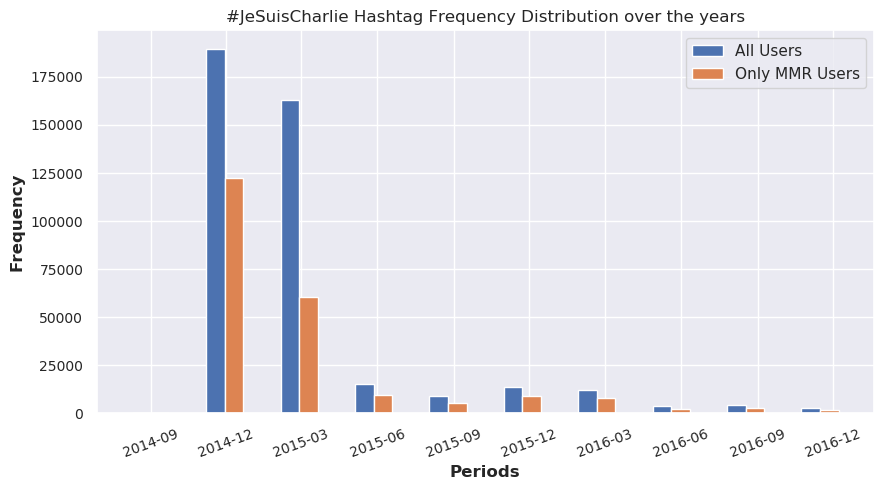

In [321]:
# Plot hashtag frequency distribution
plot_hashtag_frequency_distribution(all_tweets_dates, subgraph_tweets_dates, hashtag_full)

The **#JeSuisCharlie** hashtag doesn't have a really steady frequency distribution over the years in the timeframe we're considering, as it can be seen from the plot above. Indeed, the great majority of the tweets have been published in the first 5 months of 2015, as expected, since the events related to the spread of the hashtags occurred in January 2015. The overall peak has been reached on January 9th, 2015, with **95777** tweets published. The histogram that only considers the MMR users, as expected, follows pretty much the same distribution as the overall one: the peak values are lower but the height difference between the bars seems to be almost identical and the peak value is **61561**, reached on January 10th, 2015.

# 3. Hashtag Subgraph Metric Analysis

In [6]:
'''# Import the biggest connected component to work on
FIn = snap.TFIn("../data/mmr_subgraph_"+hashtag+".bin")
hashtag_subgraph = snap.TUNGraph.Load(FIn)'''

## 3.1 Basic Subnetwork Properties
Hereby I show how the basic network properties of $H$ change compared to the full MMR graph, in terms of number of nodes $N$, number of links $L$ and average degree $\langle K \rangle$.

In [109]:
N = hashtag_subgraph.GetNodes()
L = hashtag_subgraph.GetEdges()
K = (2.0*L)/N
print("Nodes of H: %d" %N)
print("Edges of H: %d" %L)
print("Average Degree of H: %.3f" %K)

Nodes of H: 130173
Edges of H: 580518
Average Degree of H: 8.919


| Property | $G$ (SCC) | $H$ (Hashtag Subgraph) | % Relative to $G$
|---|---|---|---|
| **Average Degree $\langle K \rangle$** | 10,127 | 8,919 | -
| **Number of nodes $N$** | 84.510.806 | 130.173 | ~0,15%
| **Number of edges $L$** | 427.935.499 | 580.518 | ~0,13%

## 3.2 Extract Random Graphs
It would be interesting to compare a set of network properties of $H$ with the ones of $M=100$ random subgraphs *of the same size* $N$.

In [17]:
def get_random_subgraphs(graph, M, N):
    return [snap.GetRndSubGraph(graph,N) for _ in range(M)]

In [18]:
%%time
M = 100
random_subgraphs = get_random_subgraphs(graph, M, N)

CPU times: user 8min 16s, sys: 10.1 s, total: 8min 26s
Wall time: 8min 26s


In [250]:
def plot_random_subgraphs_property_distribution(random_subgraphs, data, hashtag, filename, M, N, y_ticks, labels_dict, rwidth, binwidth=None, x_ticks_rotation=0, bottom_adjust=None):
    #Figure properties
    fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 2]})
    fig.set_size_inches(12,4)
    fig.set_dpi(100)
    
    # Plot histogram
    if binwidth is None:
        # Continuous values
        counts, bins, _ = ax1.hist(data, align="mid", rwidth=rwidth)
    else:
        # Discrete values
        counts, bins, _ = ax1.hist(data, bins=range(min(data), max(data) + binwidth, binwidth), align="mid", rwidth=rwidth)
    
    # Set Histogram Axes ticks
    ax1.set_xticks(bins)
    ax1.set_yticks(y_ticks)
    ax1.xaxis.set_tick_params(rotation=x_ticks_rotation)
    
    # Set Histogram Axes labels and title
    ax1.set_ylabel(labels_dict["y_label"], fontsize=10, fontweight="bold")
    ax1.set_title(labels_dict["hist_title"])
    
    # Plot Boxplot
    sns.boxplot(data, ax=ax2)
    
    # Set Boxplot axes labels and title
    ax2.set_title(labels_dict["boxplot_title"])
    
    # Set common params
    for ax in (ax1, ax2):
        ax.set_xlabel(labels_dict["x_label"], fontsize=10, fontweight="bold")
        ax.tick_params(labelsize=8)
    
    fig.set_tight_layout(False)
    if not bottom_adjust is None:
        fig.subplots_adjust(bottom=bottom_adjust)
    plt.savefig(os.path.join(pictures_path,hashtag+"_"+filename+".png"))
    plt.show()

## 3.3 Average Degree Comparison
The average degree gives another useful insight closely related to the *network density*. It's worth pointing out that, since the degree is a function of $N$ and $L$, in this case the average degree distribution would be the same as the *edges count distribution* because $N$ is fixed.

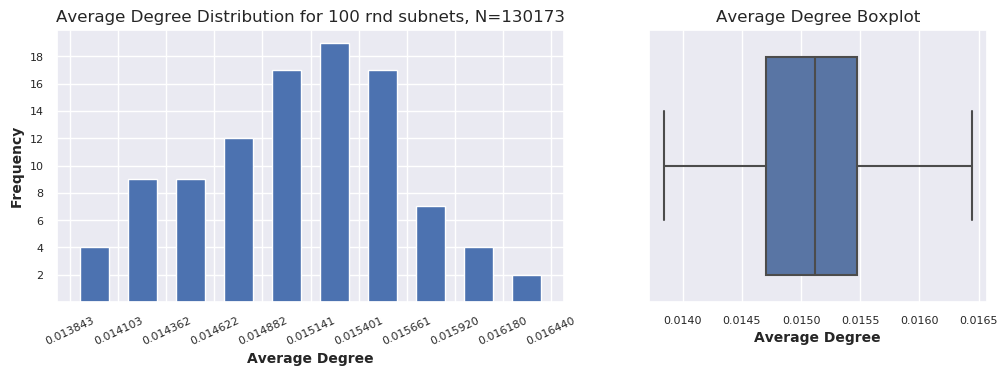

In [305]:
data = [(2.0*rnd.GetEdges())/rnd.GetNodes() for rnd in random_subgraphs]
y_ticks = range(int(min(counts)), int(max(counts)), 2)
rwidth = 0.6
x_ticks_rotation = 25
labels_dict = {
    "x_label": "Average Degree",
    "y_label": "Frequency",
    "hist_title": "Average Degree Distribution for %d rnd subnets, N=%d" %(M, N),
    "boxplot_title": "Average Degree Boxplot"
}
bottom_adjust = 0.2
filename = "random_subgraphs_average_degree_distribution"
plot_random_subgraphs_property_distribution(random_subgraphs, data, hashtag_full, filename, M, N, y_ticks, labels_dict, rwidth, x_ticks_rotation=x_ticks_rotation, bottom_adjust=bottom_adjust)

Given 100 random subgraphs of same size as $H$, it's clear that $\langle K \rangle _H=8,919$ is shifted by a large offset compared to the mean average degree (**~0,015**) shown in the boxplot above. It would be meaningless to show a vertical line corresponding to the value of $\langle K \rangle _H$, as it would represent a clear outlier.

## 3.4 Median Degree Comparison

In [241]:
def get_median_degree(graph):
    DegToCntV = snap.TIntPrV()
    snap.GetDegCnt(rnd, DegToCntV)
    deg_counter = [(el.GetVal1(), el.GetVal2()) for el in DegToCntV]
    return max(deg_counter, key=lambda x: x[1])

random_median_degrees = [get_median_degree(rnd) for rnd in random_subgraphs]
hashtag_median_degree = get_median_degree(hashtag_subgraph)
print("The median degree for the hashtag network is: %d" %hashtag_median_degree[0])
print("The unique values of median degrees for all random networks are:")
print(list(set(map(lambda x: x[0], random_median_degrees))))

The median degree for the hashtag network is: 0
The unique values of median degrees for all random networks are:
[0]


Apparently the median degree (i.e. the degree that most of the nodes in the network have) of each random subgraph is 0, which means that the random networks have a high number of **isolated nodes** (i.e. *Zero-Degree nodes*) compared to the hashtag subgraph. Let's show more info about the Zero-Degree nodes:

In [236]:
hashtag_zero_deg_nodes = snap.CntDegNodes(hashtag_subgraph, 0)
avg_random_zero_deg_nodes = np.mean([snap.CntDegNodes(rnd, 0) for rnd in random_subgraphs])
print("Hashtag subgraph has %d Zero-Degree nodes (%.2f%% of %d)" %(hashtag_zero_deg_nodes, hashtag_zero_deg_nodes*100.0/N, N))
print("Random subgraphs (on average) have %.3f Zero-Degree nodes (%.2f%% of %d)" %(avg_random_zero_deg_nodes, avg_random_zero_deg_nodes*100.0/N, N))

Hashtag subgraph has 46021 Zero-Degree nodes (35.35% of 130173)
Random subgraphs (on average) have 128331.750 Zero-Degree nodes (98.59% of 130173)


| Subgraph(s) | Average Degree $\langle K \rangle$ | Median Degree | Zero-Degree Nodes | % Zero-Degree Nodes Relative to $N$
|---|---|---|---|---|
| $H$ | 8,919 | 0 | 46.021 | 35,35%
| $M=100$ Random Subgraphs | ~0,015 | 0 | 128331,750 | 98,59%

This provides an alternative perspective to what already found with the average degree distribution above. However, a relatively high number of nodes in $H$ (**35,35%**) are Zero-Degree nodes, therefore its median degree and the median degrees of the random subgraphs are actually the same. By the other side, the mean of the number of Zero-Degree nodes for the random subgraphs is significantly higher (**98,59%** of the total nodes). Therefore, although the median degree actually coincides, there are meaningful differences between the hashtag subgraph and the random ones.

## 3.5 Degree Distribution Comparison
By comparing the degree distribution we would be able to sum up whatever has been said concerning the degree-related properties of the subgraphs.

In [266]:
# Get degree distribution of hashtag subgraph
def get_degree_distribution_hashtag_subgraph(hashtag_subgraph, N):
    DegToCntV_H = snap.TIntPrV()
    snap.GetDegCnt(hashtag_subgraph, DegToCntV_H)
    return [(item.GetVal1(), item.GetVal2() * 1.0 / N) for item in DegToCntV]

# Get mean of degree distributions of random subgraphs
# Get a unique list and do the average of the same degrees frequencies
def get_degree_distribution_random_subgraphs(random_subgraphs, N):
    random_degree_distribution = {} # Save degree values as keys and list of frequencies as values
    for rnd in random_subgraphs:
        DegToCntV_rnd = snap.TIntPrV()
        snap.GetDegCnt(rnd, DegToCntV_rnd)
        for el in DegToCntV_rnd:
            if el.GetVal1() in random_degree_distribution:
                random_degree_distribution[el.GetVal1()].append(el.GetVal2())
            else:
                random_degree_distribution[el.GetVal1()] = [el.GetVal2()]

    # Calculate average value for each degree
    for key in random_degree_distribution:
        random_degree_distribution[key] = np.mean(random_degree_distribution[key])*1.0/N

    # Convert to dict
    return random_degree_distribution.items()

In [267]:
random_degree_distribution = get_degree_distribution_random_subgraphs(random_subgraphs, N)
hashtag_subgraph_degree_distribution = get_degree_distribution_hashtag_subgraph(hashtag_subgraph, N)

In [314]:
def plot_degree_distribution_comparison(hashtag_degree_distribution, random_degree_distribution, labels_dict, linestyle, hashtag, fig_filename):
    x_hashtag = map(lambda x: x[0], hashtag_degree_distribution)
    y_hashtag = map(lambda x: x[1], hashtag_degree_distribution)
    x_rnd = map(lambda x: x[0], random_degree_distribution)
    y_rnd = map(lambda x: x[1], random_degree_distribution)

    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, squeeze=False)
    fig.set_size_inches(14,10)
    fig.set_dpi(120)
    
    ax1.plot(x_hashtag, y_hashtag, linestyle)
    ax3.plot(x_rnd, y_rnd, linestyle)
    ax2.loglog(x_hashtag, y_hashtag, linestyle)
    ax4.loglog(x_rnd, y_rnd, linestyle)
    
    # Common properties
    for ax in [ax1, ax2, ax3, ax4]:
        ax.tick_params(labelsize=8)
    for ax in (ax1, ax3):
        ax.set_xlabel(labels_dict["normal_x_label"], fontsize=10, fontweight="bold")
        ax.set_ylabel(labels_dict["normal_y_label"], fontsize=10, fontweight="bold")
        
    for ax in (ax2, ax4):
        ax.set_xlabel(labels_dict["log_x_label"], fontsize=10, fontweight="bold")
        ax.set_ylabel(labels_dict["log_y_label"], fontsize=10, fontweight="bold")
    ax1.set_title(labels_dict["hashtag_normal_title"])
    ax2.set_title(labels_dict["hashtag_log_title"])
    ax3.set_title(labels_dict["random_normal_title"])
    ax4.set_title(labels_dict["random_log_title"])
    
    # Save and show figure
    fig.set_tight_layout(False)
    fig.subplots_adjust(hspace=0.3)
    plt.savefig(os.path.join(pictures_path,hashtag+"_"+fig_filename+".png"))
    plt.show()

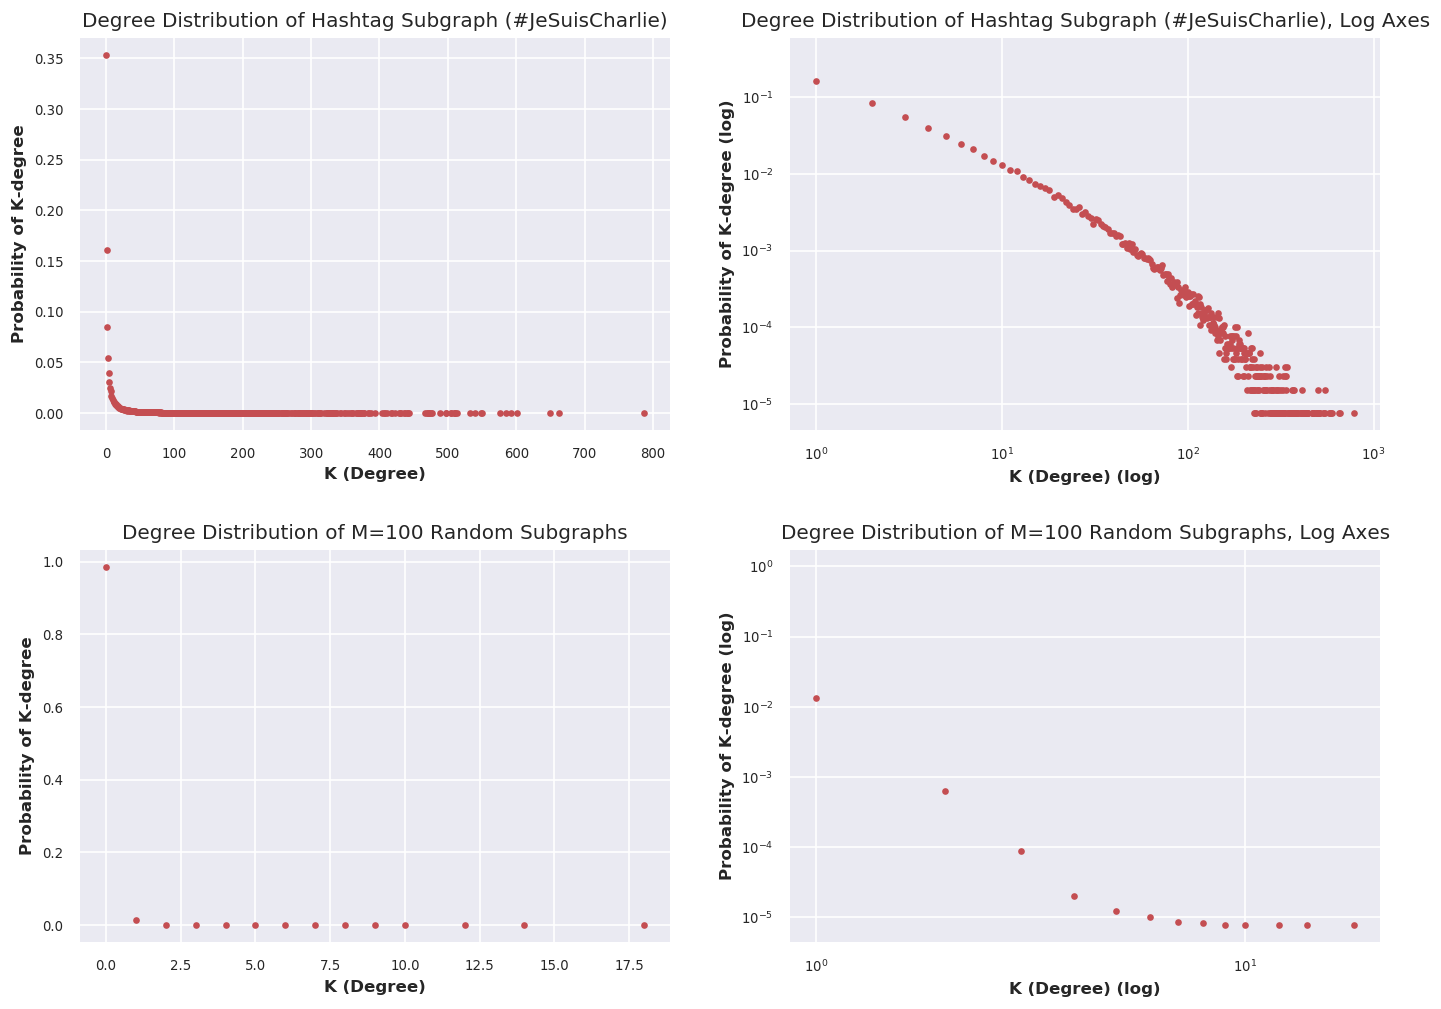

In [317]:
linestyle = "r."
labels_dict = {
    "normal_x_label": "K (Degree)",
    "normal_y_label": "Probability of K-degree",
    "hashtag_normal_title": "Degree Distribution of Hashtag Subgraph (%s)" %hashtag_full,
    "random_normal_title": "Degree Distribution of M=%d Random Subgraphs" %M,
    "log_x_label": "K (Degree) (log)",
    "log_y_label": "Probability of K-degree (log)",
    "hashtag_log_title": "Degree Distribution of Hashtag Subgraph (%s), Log Axes" %hashtag_full,
    "random_log_title": "Degree Distribution of M=%d Random Subgraphs, Log Axes" %M,
}
plot_degree_distribution_comparison(hashtag_subgraph_degree_distribution, random_degree_distribution, labels_dict, linestyle, hashtag_full,"deg_dist_comparison_with_random")

The degree distribution of $H$ basically follows the same trend as $G$, clearly visible with the logarithmic version. It is clear that the degree ranges are very different between $H$ and the random subgraphs. For the former, the maximum degree is close to 800 whereas in the latter it's only 18.

## 3.6 Graph Density Comparison

In [9]:
scc = snap.GetMxScc(hashtag_subgraph)

In [10]:
scc.GetNodes()

80374

In [11]:
scc.GetEdges()

578202

In [221]:
snap.CntDegNodes(hashtag_subgraph, 0)

46021